# Multi-Sequence MRI to Planning CT Registration Pipeline
**Purpose:** Align multi-sequence MRI (T2 SPACE, T2 SSFSE, T2 Prostate) to planning CT for enhanced radiation therapy target delineation

**Workflow:**
1. Scan DICOM directory and classify MRI sequences and planning CT
2. Build 3D volumes from sorted slices
3. Resample to 5mm isotropic resolution
4. Perform mutual information-based rigid registration (MRI → Planning CT)
5. Validate alignment quality with intensity metrics
6. Visualize multi-sequence overlays with quality assessment
7. Export aligned volumes as DICOM for treatment planning

**Requirements:** pydicom, numpy, matplotlib, scipy, scikit-image

**Dataset:** Includes T2 SPACE (176 slices), T2 SSFSE (36 slices), T2 Prostate axial (38 slices), T2 Prostate sagittal (21 slices), and Planning CT (334 slices)

In [1]:
# === 1. ENVIRONMENT SETUP AND DEPENDENCY CHECK ===
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Check and install dependencies
try:
    import pydicom
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import ndimage
    from scipy.optimize import minimize
    from scipy.ndimage import affine_transform
    print("✓ All dependencies loaded successfully")
except ImportError as e:
    print(f"Missing dependency: {e}")
    print("Installing required packages...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", 
                          "pydicom", "numpy", "matplotlib", "scipy", "scikit-image"])
    print("Please restart the kernel and run again")
    raise

print("Python version:", sys.version)
print("NumPy version:", np.__version__)

✓ All dependencies loaded successfully
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
NumPy version: 2.3.3


In [2]:
# === 2. CONFIGURATION AND DIRECTORY SETUP ===
INPUT_DICOM_DIR = r'c:\Users\zhaoanr\Desktop\WholePelvis2'
OUTPUT_DICOM_DIR = r'c:\Users\zhaoanr\Desktop\ct2-mri-registration\AlignedMRI_CT'

if not os.path.isdir(INPUT_DICOM_DIR):
    raise FileNotFoundError(f"Directory not found: {INPUT_DICOM_DIR}")

os.makedirs(OUTPUT_DICOM_DIR, exist_ok=True)

print(f"✓ Input directory: {INPUT_DICOM_DIR}")
print(f"✓ Output directory: {OUTPUT_DICOM_DIR}")

✓ Input directory: c:\Users\zhaoanr\Desktop\WholePelvis2
✓ Output directory: c:\Users\zhaoanr\Desktop\ct2-mri-registration\AlignedMRI_CT


In [3]:
# === 3. DICOM DIRECTORY SCANNING ===
from collections import defaultdict

def scan_dicom_directory(root_dir):
    """Recursively scan directory and classify DICOM series by UID and modality."""
    series_map = defaultdict(lambda: {'header': None, 'modality': 'Unknown', 'files': []})
    file_count = 0
    skipped_files = 0
    
    print(f"Scanning: {root_dir}")
    
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            try:
                header = pydicom.dcmread(filepath, stop_before_pixels=True, force=True)
                file_count += 1
                
                if 'SeriesInstanceUID' not in header or 'Modality' not in header:
                    skipped_files += 1
                    continue
                
                series_uid = header.SeriesInstanceUID
                modality = header.Modality.upper()
                
                if series_map[series_uid]['header'] is None:
                    series_map[series_uid]['header'] = header
                    series_map[series_uid]['modality'] = modality
                
                series_map[series_uid]['files'].append(filepath)
                
            except Exception:
                skipped_files += 1
                continue
    
    print(f"  Processed: {file_count} files")
    print(f"  Skipped: {skipped_files} files")
    print(f"  Found: {len(series_map)} unique series")
    
    return dict(series_map)

series_map = scan_dicom_directory(INPUT_DICOM_DIR)

Scanning: c:\Users\zhaoanr\Desktop\WholePelvis2
  Processed: 4886 files
  Skipped: 0 files
  Found: 231 unique series


In [4]:
# === 4. SERIES CLASSIFICATION (FOCUS ON AXIAL SEQUENCES) ===

def classify_series(series_map):
    """Bin series by modality, focusing on axial MRI and Planning CT."""
    bins = {
        'MRI_T2_SPACE': {},
        'MRI_T2_PROSTATE_AX': {},
        'MRI_OTHER': {},
        'CT_PLANNING_SIM': {},
        'CT_OTHER': {}
    }
    
    # Identify planning CT study
    pet_series = [(uid, info) for uid, info in series_map.items() 
                  if info['modality'] in ['PT', 'PET']]
    
    original_study_uid = pet_series[0][1]['header'].StudyInstanceUID if pet_series else None
    
    for series_uid, series_info in series_map.items():
        modality = series_info['modality']
        header = series_info['header']
        study_uid = header.get('StudyInstanceUID', None)
        series_desc = str(header.get('SeriesDescription', '')).upper()
        
        if modality in ['MR', 'MRI']:
            if 'T2' in series_desc and 'SPACE' in series_desc:
                bins['MRI_T2_SPACE'][series_uid] = series_info
            elif 'T2' in series_desc and 'PROSTATE' in series_desc and ('AX' in series_desc or 'AXIAL' in series_desc):
                bins['MRI_T2_PROSTATE_AX'][series_uid] = series_info
            else:
                bins['MRI_OTHER'][series_uid] = series_info
        
        elif modality == 'CT':
            if original_study_uid and study_uid != original_study_uid:
                if any(kw in series_desc for kw in ['SIM', 'PLAN', 'IMAR', 'PELVIS', 'RT']):
                    bins['CT_PLANNING_SIM'][series_uid] = series_info
                else:
                    bins['CT_OTHER'][series_uid] = series_info
            else:
                bins['CT_OTHER'][series_uid] = series_info
    
    return bins

bins = classify_series(series_map)

print("\n" + "="*60)
print("SERIES CLASSIFICATION (AXIAL SEQUENCES)")
print("="*60)

for bin_name in ['MRI_T2_SPACE', 'MRI_T2_PROSTATE_AX', 'CT_PLANNING_SIM']:
    if bins[bin_name]:
        print(f"\n{bin_name}: {len(bins[bin_name])} series")
        for series_uid, series_info in bins[bin_name].items():
            header = series_info['header']
            desc = header.get('SeriesDescription', 'N/A')
            num_files = len(series_info['files'])
            print(f"  • '{desc}' ({num_files} files)")

print("="*60)


SERIES CLASSIFICATION (AXIAL SEQUENCES)

MRI_T2_SPACE: 1 series
  • 'AX T2 SPACE' (176 files)

MRI_T2_PROSTATE_AX: 1 series
  • 'AX T2 PROSTATE DR' (38 files)

CT_PLANNING_SIM: 1 series
  • 'PELVIS  1.5  Br32  3 iMAR' (334 files)


In [5]:
# === 5. ROBUST SLICE SORTING ===

def sort_series_by_position(file_list):
    """Sort DICOM slices by ImagePositionPatient Z or InstanceNumber."""
    import pandas as pd
    
    slice_data = []
    for filepath in file_list:
        try:
            header = pydicom.dcmread(filepath, stop_before_pixels=True, force=True)
            
            sort_key = None
            if 'ImagePositionPatient' in header:
                try:
                    sort_key = float(header.ImagePositionPatient[2])
                except (TypeError, ValueError, IndexError):
                    pass
            
            if sort_key is None and 'InstanceNumber' in header:
                try:
                    sort_key = int(header.InstanceNumber)
                except (TypeError, ValueError):
                    pass
            
            if sort_key is not None:
                slice_data.append({'filepath': filepath, 'SortKey': sort_key})
        
        except Exception:
            continue
    
    if not slice_data:
        raise ValueError("No sortable slices found in series")
    
    df = pd.DataFrame(slice_data)
    df = df.sort_values('SortKey', ascending=True).reset_index(drop=True)
    return df

print("✓ Slice sorting function ready")

✓ Slice sorting function ready


In [6]:
# === 6. VOLUME ASSEMBLY ===

def build_volume_from_series(file_list, series_name="Volume"):
    """Build 3D volume from sorted DICOM slices."""
    df_sorted = sort_series_by_position(file_list)
    depth = len(df_sorted)
    
    first_ds = pydicom.dcmread(df_sorted.iloc[0]['filepath'], force=True)
    rows, cols = first_ds.pixel_array.shape
    
    volume = np.zeros((rows, cols, depth), dtype=np.float32)
    
    print(f"Building {series_name}: ({rows}, {cols}, {depth})")
    
    for i in range(depth):
        try:
            ds = pydicom.dcmread(df_sorted.iloc[i]['filepath'], force=True)
            arr = ds.pixel_array.astype(np.float32)
            
            slope = float(ds.get('RescaleSlope', 1.0))
            intercept = float(ds.get('RescaleIntercept', 0.0))
            arr = arr * slope + intercept
            
            if arr.shape == (rows, cols):
                volume[:, :, i] = arr
            else:
                tmp = np.zeros((rows, cols), dtype=np.float32)
                min_r = min(arr.shape[0], rows)
                min_c = min(arr.shape[1], cols)
                tmp[:min_r, :min_c] = arr[:min_r, :min_c]
                volume[:, :, i] = tmp
        
        except Exception as e:
            print(f"  ⚠ Error slice {i}: {e}")
            volume[:, :, i] = 0
    
    return volume, df_sorted

print("\n" + "="*60)
print("BUILDING VOLUMES")
print("="*60)

# Planning CT
if not bins['CT_PLANNING_SIM']:
    raise ValueError("No CT_PLANNING_SIM series found")
ct_plan_uid = list(bins['CT_PLANNING_SIM'].keys())[0]
ct_plan_files = bins['CT_PLANNING_SIM'][ct_plan_uid]['files']
CT_PLAN, df_ct_plan = build_volume_from_series(ct_plan_files, "CT_Planning")

# MRI volumes (axial only)
mri_volumes = {}
mri_dataframes = {}

if bins['MRI_T2_SPACE']:
    t2_space_uid = list(bins['MRI_T2_SPACE'].keys())[0]
    t2_space_files = bins['MRI_T2_SPACE'][t2_space_uid]['files']
    mri_volumes['T2_SPACE'], mri_dataframes['T2_SPACE'] = build_volume_from_series(
        t2_space_files, "MRI_T2_SPACE")

if bins['MRI_T2_PROSTATE_AX']:
    t2_pros_ax_uid = list(bins['MRI_T2_PROSTATE_AX'].keys())[0]
    t2_pros_ax_files = bins['MRI_T2_PROSTATE_AX'][t2_pros_ax_uid]['files']
    mri_volumes['T2_PROSTATE_AX'], mri_dataframes['T2_PROSTATE_AX'] = build_volume_from_series(
        t2_pros_ax_files, "MRI_T2_PROSTATE_AX")

print(f"\n✓ Built Planning CT and {len(mri_volumes)} axial MRI sequences")


BUILDING VOLUMES
Building CT_Planning: (512, 512, 334)
Building MRI_T2_SPACE: (768, 768, 176)
Building MRI_T2_PROSTATE_AX: (512, 512, 38)

✓ Built Planning CT and 2 axial MRI sequences


In [7]:
# === 7. EXTRACT METADATA ===

def extract_volume_metadata(df_sorted):
    """Extract spatial metadata from sorted DICOM series."""
    first_ds = pydicom.dcmread(df_sorted.iloc[0]['filepath'], stop_before_pixels=True, force=True)
    
    pixel_spacing = [float(x) for x in first_ds.get('PixelSpacing', [1.0, 1.0])]
    
    if len(df_sorted) > 1:
        try:
            pos0 = np.array([float(x) for x in first_ds.ImagePositionPatient])
            ds1 = pydicom.dcmread(df_sorted.iloc[1]['filepath'], stop_before_pixels=True, force=True)
            pos1 = np.array([float(x) for x in ds1.ImagePositionPatient])
            slice_spacing = float(np.linalg.norm(pos1 - pos0))
        except Exception:
            slice_spacing = float(first_ds.get('SliceThickness', 1.0))
    else:
        slice_spacing = float(first_ds.get('SliceThickness', 1.0))
    
    origin = np.array([float(x) for x in first_ds.get('ImagePositionPatient', [0, 0, 0])])
    orientation = [float(x) for x in first_ds.get('ImageOrientationPatient', [1,0,0,0,1,0])]
    
    metadata = {
        'spacing': [pixel_spacing[0], pixel_spacing[1], slice_spacing],
        'origin': origin,
        'orientation': orientation,
        'dimensions': [int(first_ds.Rows), int(first_ds.Columns), len(df_sorted)]
    }
    
    return metadata

ct_plan_meta = extract_volume_metadata(df_ct_plan)
mri_metadata = {}
for name, df in mri_dataframes.items():
    mri_metadata[name] = extract_volume_metadata(df)

print("\nVolume Metadata:")
print(f"CT_PLAN: spacing={np.round(ct_plan_meta['spacing'], 2)} mm")
for name, meta in mri_metadata.items():
    print(f"{name}: spacing={np.round(meta['spacing'], 2)} mm")


Volume Metadata:
CT_PLAN: spacing=[0.98 0.98 1.5 ] mm
T2_SPACE: spacing=[0.49 0.49 1.5 ] mm
T2_PROSTATE_AX: spacing=[0.35 0.35 3.  ] mm


In [8]:
# === 8. ISOTROPIC RESAMPLING TO 2mm ===

def resample_to_isotropic(volume, original_spacing, target_spacing=2.0, order=1):
    """Resample volume to isotropic voxel spacing."""
    scale = np.array(original_spacing) / target_spacing
    new_shape = np.round(np.array(volume.shape) * scale).astype(int)
    
    coords = np.meshgrid(
        np.linspace(0, volume.shape[0]-1, new_shape[0]),
        np.linspace(0, volume.shape[1]-1, new_shape[1]),
        np.linspace(0, volume.shape[2]-1, new_shape[2]),
        indexing='ij'
    )
    
    coords = np.stack(coords, axis=0)
    
    mean_val = float(np.mean(volume))
    cval = -1024.0 if mean_val < -500 else 0.0
    
    resampled = ndimage.map_coordinates(
        volume, coords, order=order, mode='constant', cval=cval
    ).astype(np.float32)
    
    return resampled

print("\n" + "="*60)
print("RESAMPLING TO 2mm ISOTROPIC")
print("="*60)

TARGET_SPACING = 2.0

ct_plan_iso = resample_to_isotropic(CT_PLAN, ct_plan_meta['spacing'], TARGET_SPACING)
ct_plan_iso_meta = ct_plan_meta.copy()
ct_plan_iso_meta['spacing'] = [TARGET_SPACING, TARGET_SPACING, TARGET_SPACING]
ct_plan_iso_meta['dimensions'] = list(ct_plan_iso.shape)
print(f"CT_PLAN: {CT_PLAN.shape} → {ct_plan_iso.shape}")

mri_iso_volumes = {}
mri_iso_metadata = {}

for name, volume in mri_volumes.items():
    mri_iso_volumes[name] = resample_to_isotropic(volume, mri_metadata[name]['spacing'], TARGET_SPACING)
    mri_iso_metadata[name] = mri_metadata[name].copy()
    mri_iso_metadata[name]['spacing'] = [TARGET_SPACING, TARGET_SPACING, TARGET_SPACING]
    mri_iso_metadata[name]['dimensions'] = list(mri_iso_volumes[name].shape)
    print(f"{name}: {volume.shape} → {mri_iso_volumes[name].shape}")

print(f"\n✓ All volumes resampled to {TARGET_SPACING}mm isotropic")


RESAMPLING TO 2mm ISOTROPIC
CT_PLAN: (512, 512, 334) → (250, 250, 250)
T2_SPACE: (768, 768, 176) → (190, 190, 132)
T2_PROSTATE_AX: (512, 512, 38) → (90, 90, 57)

✓ All volumes resampled to 2.0mm isotropic


In [9]:
# === 9. ORIENTATION VERIFICATION ===

print("\n" + "="*60)
print("ORIENTATION VERIFICATION")
print("="*60)

ct_iop = np.array(ct_plan_meta['orientation'])
ct_slice_normal = np.cross(ct_iop[0:3], ct_iop[3:6])
ct_slice_normal = ct_slice_normal / np.linalg.norm(ct_slice_normal)

print(f"\nCT slice normal: {ct_slice_normal}")
print(f"CT orientation: {'Axial' if abs(ct_slice_normal[2]) > 0.9 else 'Non-axial'}")

mri_iso_filtered = {}

for name, vol in mri_iso_volumes.items():
    meta = mri_iso_metadata[name]
    iop = np.array(meta['orientation'])
    slice_normal = np.cross(iop[0:3], iop[3:6])
    slice_normal = slice_normal / np.linalg.norm(slice_normal)
    
    angle = np.degrees(np.arccos(np.clip(np.dot(ct_slice_normal, slice_normal), -1, 1)))
    
    if abs(slice_normal[2]) > 0.9:
        plane = "Axial"
    elif abs(slice_normal[1]) > 0.9:
        plane = "Coronal"
    elif abs(slice_normal[0]) > 0.9:
        plane = "Sagittal"
    else:
        plane = "Oblique"
    
    print(f"\n{name}: {plane} ({angle:.1f}° from CT)")
    
    if angle < 15:
        mri_iso_filtered[name] = vol
        print(f"  ✓ Will register")
    else:
        print(f"  ✗ Skipped (wrong plane)")

print(f"\n✓ {len(mri_iso_filtered)} sequences ready for registration")


ORIENTATION VERIFICATION

CT slice normal: [0. 0. 1.]
CT orientation: Axial

T2_SPACE: Axial (0.0° from CT)
  ✓ Will register

T2_PROSTATE_AX: Axial (0.0° from CT)
  ✓ Will register

✓ 2 sequences ready for registration


In [10]:
# === 10. REGISTRATION FUNCTIONS (with bone helpers) ===

def compute_mutual_information_robust(fixed, moving, bins=32, max_samples=None, mask=None):
    """Compute normalized mutual information with optional random subsampling."""
    fixed_flat = fixed.ravel()
    moving_flat = moving.ravel()

    if mask is None:
        fixed_thresh = np.percentile(fixed_flat[fixed_flat > np.min(fixed_flat)], 5)
        moving_thresh = np.percentile(moving_flat[moving_flat > np.min(moving_flat)], 5)
        mask = (fixed_flat > fixed_thresh) & (moving_flat > moving_thresh)
        mask &= np.isfinite(fixed_flat) & np.isfinite(moving_flat)
    else:
        mask = mask.astype(bool).ravel()

    idx = np.flatnonzero(mask)
    if idx.size < 1000:
        return 0.0

    if max_samples is not None and idx.size > max_samples:
        rng = np.random.default_rng(42)
        idx = rng.choice(idx, size=max_samples, replace=False)

    fixed_valid = fixed_flat[idx]
    moving_valid = moving_flat[idx]

    hist_2d, _, _ = np.histogram2d(fixed_valid, moving_valid, bins=bins)
    from scipy.ndimage import gaussian_filter
    hist_2d = gaussian_filter(hist_2d, sigma=0.5)

    pxy = hist_2d / (float(np.sum(hist_2d)) + 1e-10)
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 1e-10

    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / (px_py[nzs] + 1e-10)))
    h_x = -np.sum(px[px > 1e-10] * np.log(px[px > 1e-10]))
    h_y = -np.sum(py[py > 1e-10] * np.log(py[py > 1e-10]))
    nmi = 2.0 * mi / (h_x + h_y) if (h_x + h_y) > 0 else 0.0
    return nmi

def compute_body_roi(ct_volume, thresh=-500, margin=16):
    """Compute tight body ROI on CT (to shrink transform grid)."""
    mask = ct_volume > float(thresh)
    if not np.any(mask):
        return (slice(0, ct_volume.shape[0]), slice(0, ct_volume.shape[1]), slice(0, ct_volume.shape[2])), np.array([0,0,0], dtype=int)
    coords = np.argwhere(mask)
    r0, c0, k0 = coords.min(axis=0)
    r1, c1, k1 = coords.max(axis=0) + 1
    r0 = max(0, r0 - margin); c0 = max(0, c0 - margin); k0 = max(0, k0 - margin)
    r1 = min(ct_volume.shape[0], r1 + margin)
    c1 = min(ct_volume.shape[1], c1 + margin)
    k1 = min(ct_volume.shape[2], k1 + margin)
    slices = (slice(r0, r1), slice(c0, c1), slice(k0, k1))
    origin = np.array([r0, c0, k0], dtype=float)
    return slices, origin

def rigid_transform_3d(volume, translation, rotation_angles, center, fill_value=0.0, interp_order=1):
    """Apply 3D rigid transformation with selectable interpolation order."""
    tx, ty, tz = translation
    rx, ry, rz = rotation_angles

    cx, sx = np.cos(rx), np.sin(rx)
    cy, sy = np.cos(ry), np.sin(ry)
    cz, sz = np.cos(rz), np.sin(rz)

    Rx = np.array([[1, 0, 0], [0, cx, -sx], [0, sx, cx]])
    Ry = np.array([[cy, 0, sy], [0, 1, 0], [-sy, 0, cy]])
    Rz = np.array([[cz, -sz, 0], [sz, cz, 0], [0, 0, 1]])

    R = Rz @ Ry @ Rx
    offset = center - R @ center + np.array([tx, ty, tz])

    transformed = affine_transform(
        volume, R.T, offset=offset, order=interp_order, mode='constant', cval=fill_value
    )
    return transformed

def center_embed_3d(volume, target_shape, fill_value=0.0):
    """Embed volume in center."""
    output = np.full(target_shape, fill_value, dtype=np.float32)
    start = [(target_shape[i] - volume.shape[i]) // 2 for i in range(3)]
    end = [start[i] + volume.shape[i] for i in range(3)]
    for i in range(3):
        start[i] = max(0, start[i])
        end[i] = min(target_shape[i], end[i])
    src_end = [min(volume.shape[i], end[i] - start[i]) for i in range(3)]
    output[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = \
        volume[:src_end[0], :src_end[1], :src_end[2]]
    return output, np.array(start, dtype=np.int32)

def center_crop_3d(volume, target_shape):
    """Center-crop or pad volume to target shape."""
    out = np.zeros(target_shape, dtype=volume.dtype)
    src_start = [max(0, (volume.shape[i] - target_shape[i]) // 2) for i in range(3)]
    src_end = [src_start[i] + min(volume.shape[i], target_shape[i]) for i in range(3)]
    dst_start = [max(0, (target_shape[i] - volume.shape[i]) // 2) for i in range(3)]
    dst_end = [dst_start[i] + (src_end[i] - src_start[i]) for i in range(3)]
    out[dst_start[0]:dst_end[0], dst_start[1]:dst_end[1], dst_start[2]:dst_end[2]] = \
        volume[src_start[0]:src_end[0], src_start[1]:src_end[1], src_start[2]:src_end[2]]
    return out

# ---- Bone helpers ----

def extract_bone_mask_ct(ct_volume, hu_threshold=200, sigma=0.8):
    """Binary bone mask from CT HU."""
    bone = (ct_volume > float(hu_threshold)).astype(np.float32)
    if sigma > 0:
        bone = ndimage.gaussian_filter(bone, sigma=sigma)
    return bone

def build_mri_bone_proxy(mri_volume, sigma=1.0):
    """
    Bone-likeness proxy for MRI: strong edges with low intensity inside body.
    Returns a float map in [0,1].
    """
    v = mri_volume.astype(np.float32)
    pos = v[v > 0]
    if pos.size == 0:
        return np.zeros_like(v, dtype=np.float32)
    p1, p99 = np.percentile(pos, [1, 99])
    v_norm = np.clip((v - p1) / (p99 - p1 + 1e-8), 0, 1)

    # Body mask from intensity
    body = v_norm > 0.15

    # Edge strength
    grad = ndimage.gaussian_gradient_magnitude(v_norm, sigma=sigma)
    g1, g99 = np.percentile(grad[body], [1, 99]) if np.any(body) else (0.0, 1.0)
    grad_n = np.clip((grad - g1) / (g99 - g1 + 1e-8), 0, 1)

    # Dark preference (bones are dark on T2)
    dark = 1.0 - v_norm
    proxy = grad_n * dark
    proxy *= body.astype(np.float32)
    proxy = ndimage.gaussian_filter(proxy, sigma=0.8)
    return proxy

def dilate_mask(mask, iterations=2):
    return ndimage.binary_dilation(mask.astype(bool), iterations=iterations)

print("✓ Registration + bone helpers loaded")

✓ Registration + bone helpers loaded


In [11]:
# === 11. MULTI-STAGE OPTIMIZATION (bone-weighted) ===

def optimize_rigid_registration_multistage(fixed, moving, initial_params=None, center_base=None, fixed_mask=None):
    """Multi-stage optimization with ROI-aware center, voxel subsampling, and optional bone mask."""
    stages = [
        {"scale": 0.20, "bins": 24, "order": 0, "maxfun": 60,  "samples": 50000,
         "bounds": [(-20,20), (-20,20), (-20,20), *[(-np.radians(20), np.radians(20))]*3]},
        {"scale": 0.40, "bins": 28, "order": 1, "maxfun": 100, "samples": 90000,
         "bounds": [(-10,10), (-10,10), (-10,10), *[(-np.radians(8), np.radians(8))]*3]},
        {"scale": 1.00, "bins": 32, "order": 1, "maxfun": 160, "samples": 120000,
         "bounds": [(-5,5), (-5,5), (-5,5), *[(-np.radians(5), np.radians(5))]*3]},
    ]

    params = np.zeros(6) if initial_params is None else np.array(initial_params, dtype=float)
    best_overall_nmi = -np.inf
    best_overall_params = params.copy()

    for si, st in enumerate(stages, start=1):
        s = st["scale"]
        print(f"  Stage {si}: {'Coarse' if s<0.3 else 'Medium' if s<0.9 else 'Fine'} ({1/s:.1f}x)...")
        fixed_s = ndimage.zoom(fixed, s, order=1)
        moving_s = ndimage.zoom(moving, s, order=1)
        center_s = (np.array(fixed.shape)/2.0 if center_base is None else np.array(center_base)) * s

        # Downscale mask if provided
        if fixed_mask is not None:
            mask_s = ndimage.zoom(fixed_mask.astype(np.float32), s, order=0) > 0.5
            sample_mask = mask_s.ravel()
        else:
            f = fixed_s
            fthr = np.percentile(f[f > f.min()], 10) if np.any(f > f.min()) else f.min()
            sample_mask = (f.ravel() > fthr)

        # Downscale initial params
        params_s = params.copy()
        params_s[0:3] *= s

        iteration = [0]
        best_nmi = [-np.inf]
        best_params = [params_s.copy()]

        def objective_level(p):
            iteration[0] += 1
            moving_tx = rigid_transform_3d(moving_s, p[0:3], p[3:6], center_s, 0.0, interp_order=st["order"])
            nmi = compute_mutual_information_robust(
                fixed_s, moving_tx, bins=st["bins"], max_samples=st["samples"], mask=sample_mask
            )
            if nmi > best_nmi[0]:
                best_nmi[0] = nmi
                best_params[0] = p.copy()
            if iteration[0] % 5 == 0:
                print(f"    Iter {iteration[0]}: NMI={nmi:.4f} (best={best_nmi[0]:.4f})")
                sys.stdout.flush()
            return -nmi

        _ = minimize(
            objective_level, params_s, method='L-BFGS-B',
            bounds=st["bounds"], options={'maxiter': 50, 'maxfun': st["maxfun"], 'disp': False}
        )

        params = best_params[0].copy()
        params[0:3] /= s
        if best_nmi[0] > best_overall_nmi:
            best_overall_nmi = best_nmi[0]
            best_overall_params = params.copy()
        print(f"    ✓ Stage {si} complete: NMI={best_nmi[0]:.4f} ({iteration[0]} evals)")

    print(f"  ✓ Final NMI={best_overall_nmi:.4f}")
    print(f"    Translation: [{best_overall_params[0]:.1f}, {best_overall_params[1]:.1f}, {best_overall_params[2]:.1f}] voxels")
    print(f"    Rotation: [{np.degrees(best_overall_params[3]):.1f}°, {np.degrees(best_overall_params[4]):.1f}°, {np.degrees(best_overall_params[5]):.1f}°]")
    return best_overall_params, best_overall_nmi

print("✓ Multi-stage optimizer ready (bone-weighted)")

✓ Multi-stage optimizer ready (bone-weighted)



DIAGNOSTIC: CT vs MRI BONE FEATURES


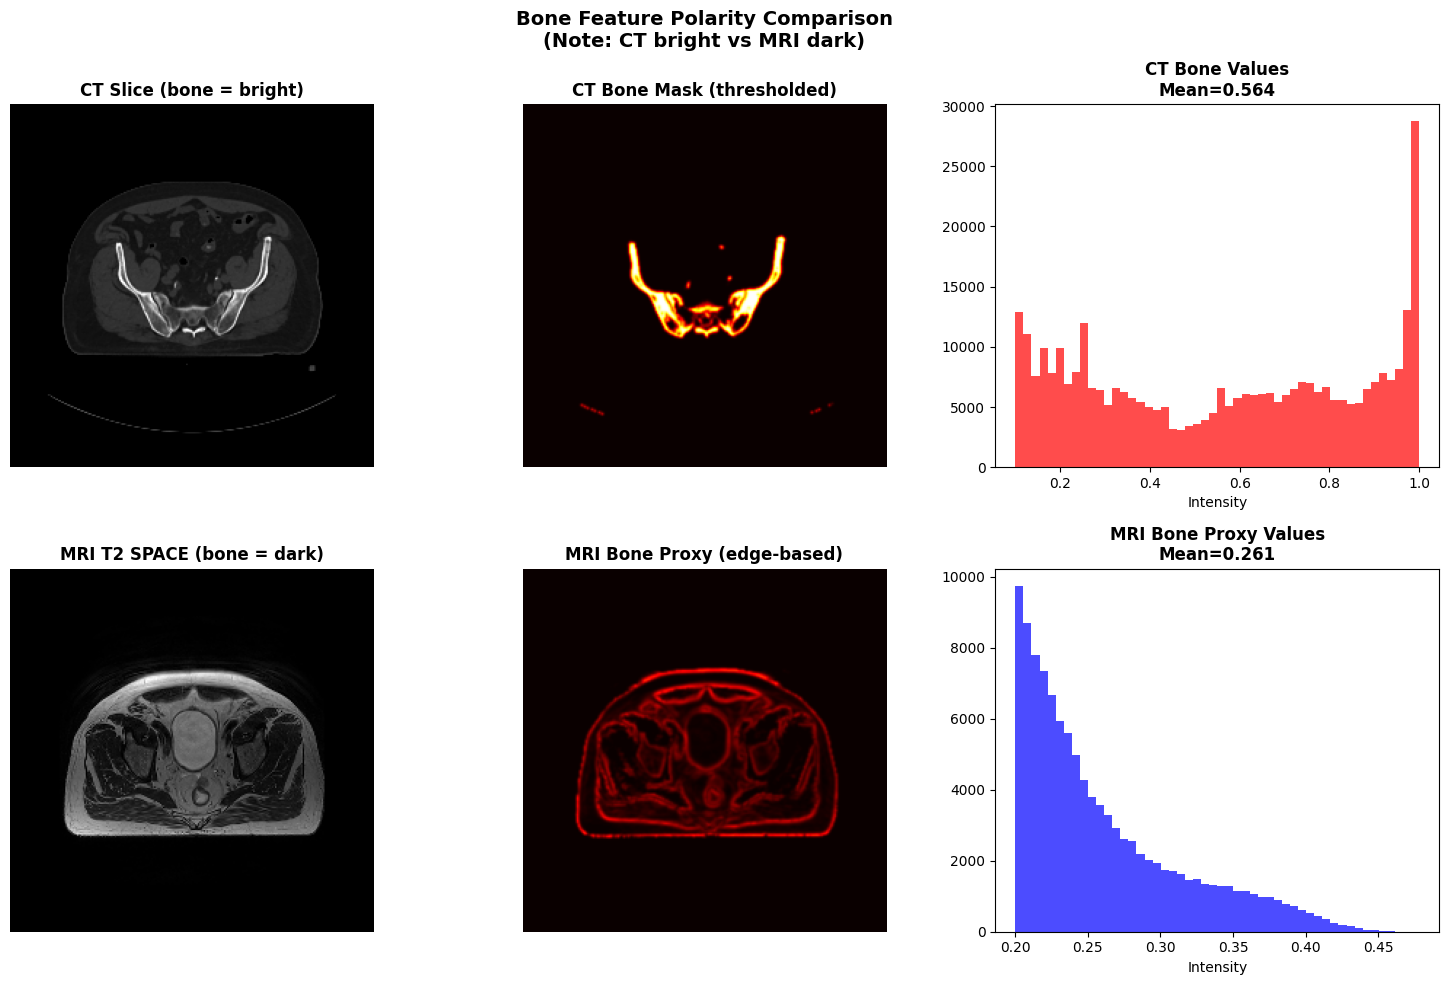


CT bone voxels: 351,769
MRI bone proxy voxels: 109,594
CT bone mean: 0.5636
MRI bone proxy mean: 0.2605
Initial overlap: 1,288 voxels (0.37% of CT bone)


In [12]:
# === 11.5 DIAGNOSTIC: BONE FEATURE COMPARISON ===

print("\n" + "="*60)
print("DIAGNOSTIC: CT vs MRI BONE FEATURES")
print("="*60)

# Get T2_SPACE for diagnosis
mri_vol = mri_iso_filtered['T2_SPACE']
aligned_init, _ = center_embed_3d(mri_vol, ct_plan_iso.shape, fill_value=0.0)

# Extract bone features
ct_bone = extract_bone_mask_ct(ct_plan_iso, hu_threshold=200, sigma=0.8)
mri_bone_proxy = build_mri_bone_proxy(aligned_init, sigma=1.0)

# Pick a representative slice (mid-pelvis)
mid_slice = ct_plan_iso.shape[2] // 2

# Visualize bone features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: CT
axes[0, 0].imshow(ct_plan_iso[:, :, mid_slice], cmap='gray', vmin=-200, vmax=1000)
axes[0, 0].set_title('CT Slice (bone = bright)', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(ct_bone[:, :, mid_slice], cmap='hot', vmin=0, vmax=1)
axes[0, 1].set_title('CT Bone Mask (thresholded)', fontweight='bold')
axes[0, 1].axis('off')

ct_bone_stats = ct_bone[ct_bone > 0.1]
axes[0, 2].hist(ct_bone_stats.ravel(), bins=50, color='red', alpha=0.7)
axes[0, 2].set_title(f'CT Bone Values\nMean={ct_bone_stats.mean():.3f}', fontweight='bold')
axes[0, 2].set_xlabel('Intensity')

# Row 2: MRI
axes[1, 0].imshow(aligned_init[:, :, mid_slice], cmap='gray')
axes[1, 0].set_title('MRI T2 SPACE (bone = dark)', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(mri_bone_proxy[:, :, mid_slice], cmap='hot', vmin=0, vmax=1)
axes[1, 1].set_title('MRI Bone Proxy (edge-based)', fontweight='bold')
axes[1, 1].axis('off')

mri_bone_stats = mri_bone_proxy[mri_bone_proxy > 0.2]
axes[1, 2].hist(mri_bone_stats.ravel(), bins=50, color='blue', alpha=0.7)
axes[1, 2].set_title(f'MRI Bone Proxy Values\nMean={mri_bone_stats.mean():.3f}', fontweight='bold')
axes[1, 2].set_xlabel('Intensity')

plt.suptitle('Bone Feature Polarity Comparison\n(Note: CT bright vs MRI dark)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation check
print(f"\nCT bone voxels: {np.sum(ct_bone > 0.1):,}")
print(f"MRI bone proxy voxels: {np.sum(mri_bone_proxy > 0.2):,}")
print(f"CT bone mean: {ct_bone[ct_bone > 0.1].mean():.4f}")
print(f"MRI bone proxy mean: {mri_bone_proxy[mri_bone_proxy > 0.2].mean():.4f}")

# Check if volumes overlap at all (should be low initially)
overlap = np.sum((ct_bone > 0.1) & (mri_bone_proxy > 0.2))
print(f"Initial overlap: {overlap:,} voxels ({100*overlap/np.sum(ct_bone > 0.1):.2f}% of CT bone)")


TESTING MULTIPLE MRI BONE EXTRACTION STRATEGIES


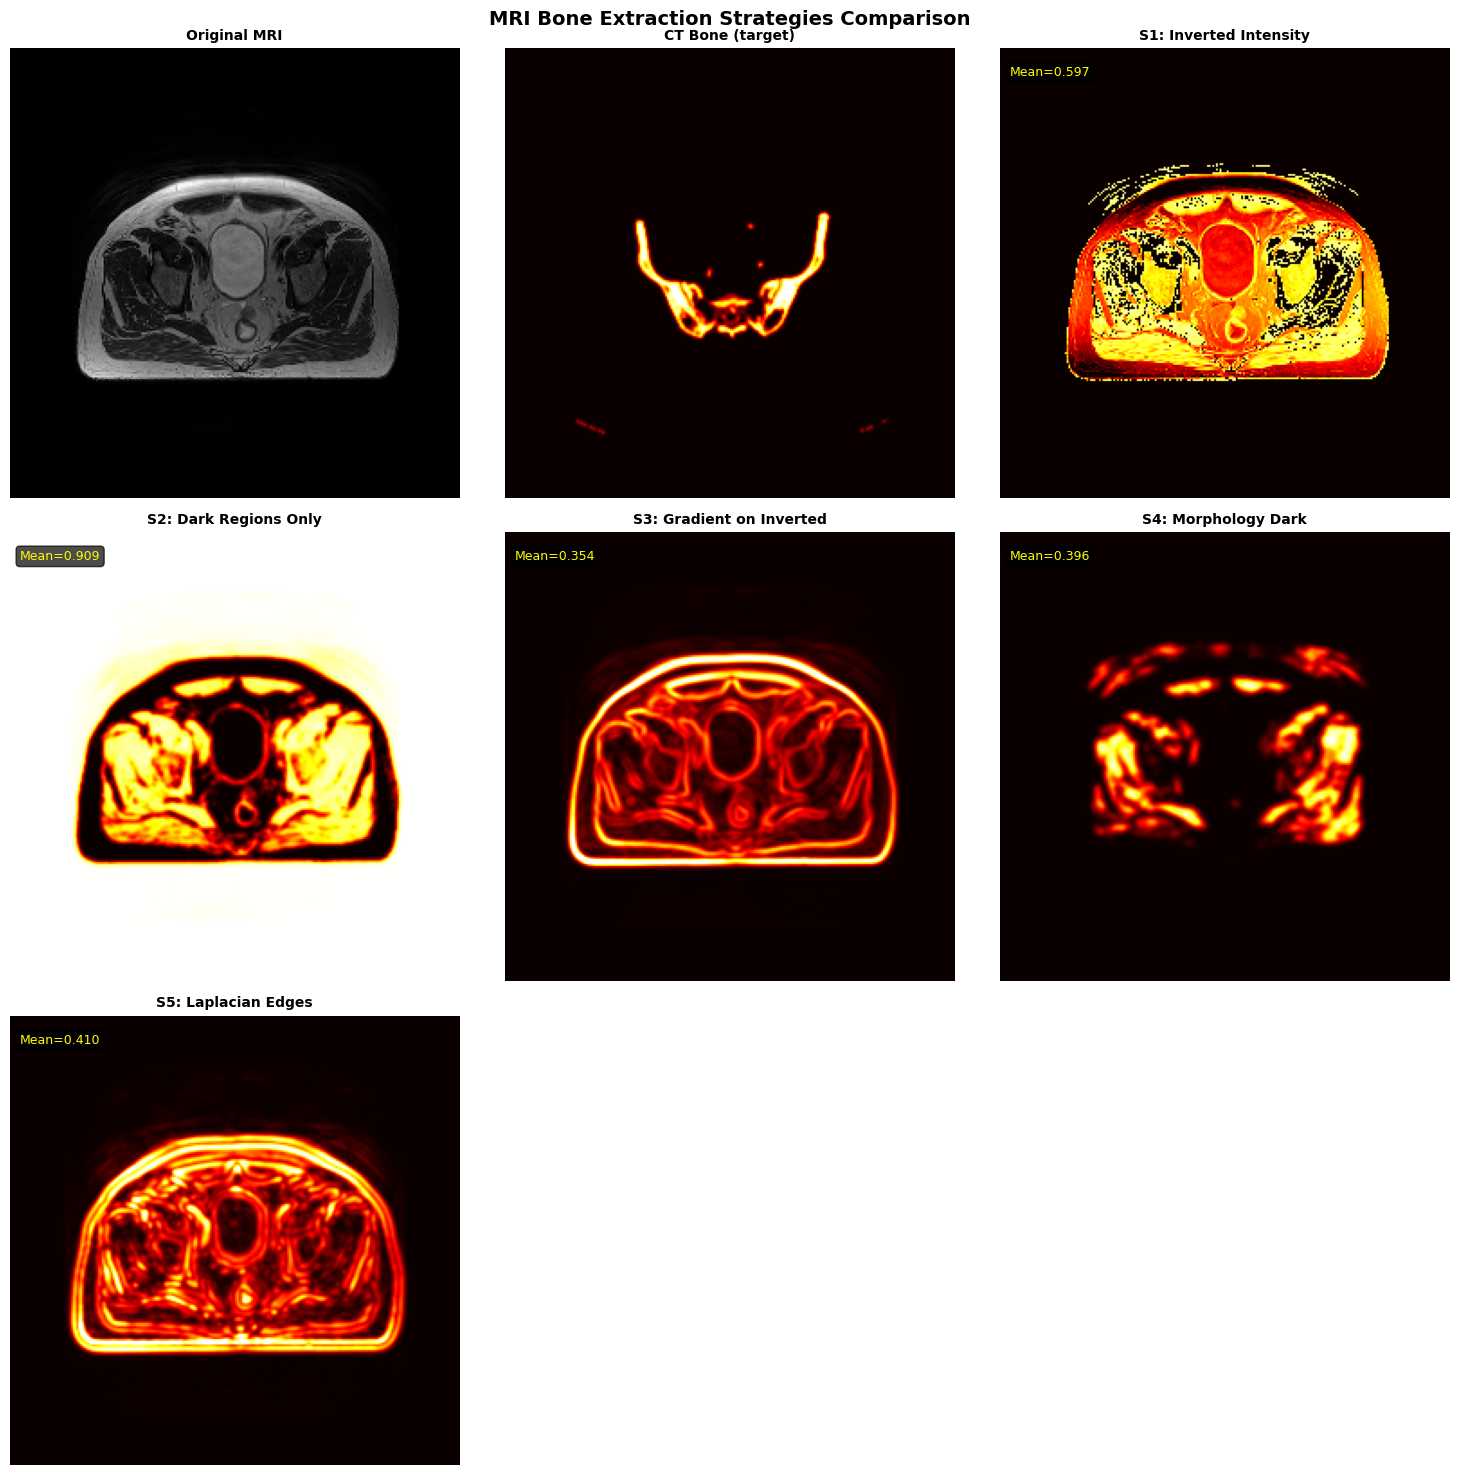


Overlap with CT bone (higher = better):
  S1: Inverted: 1,821 / 2,145 (84.9%)
  S2: Dark Only: 1,350 / 2,145 (62.9%)
  S3: Grad Inv: 1,067 / 2,145 (49.7%)
  S4: Morph: 311 / 2,145 (14.5%)
  S5: Laplacian: 1,466 / 2,145 (68.3%)


In [13]:
# === 11.6 DIAGNOSTIC: TEST MULTIPLE MRI BONE EXTRACTION STRATEGIES ===

print("\n" + "="*60)
print("TESTING MULTIPLE MRI BONE EXTRACTION STRATEGIES")
print("="*60)

mri_vol = mri_iso_filtered['T2_SPACE']
aligned_init, _ = center_embed_3d(mri_vol, ct_plan_iso.shape, fill_value=0.0)
ct_bone = extract_bone_mask_ct(ct_plan_iso, hu_threshold=200, sigma=0.8)

mid_slice = ct_plan_iso.shape[2] // 2

# Normalize MRI
mri_norm = aligned_init.astype(np.float32)
pos = mri_norm[mri_norm > 0]
p1, p99 = np.percentile(pos, [1, 99])
mri_norm = np.clip((mri_norm - p1) / (p99 - p1 + 1e-8), 0, 1)

# Strategy 1: Simple intensity inversion (dark becomes bright)
strategy1 = 1.0 - mri_norm
strategy1[mri_norm < 0.1] = 0

# Strategy 2: Low-intensity regions only (pure darkness)
strategy2 = np.zeros_like(mri_norm)
strategy2[mri_norm < 0.3] = 1.0 - mri_norm[mri_norm < 0.3]
strategy2 = ndimage.gaussian_filter(strategy2, sigma=1.0)

# Strategy 3: Gradient magnitude on inverted image
mri_inv = 1.0 - mri_norm
grad = ndimage.gaussian_gradient_magnitude(mri_inv, sigma=1.2)
strategy3 = ndimage.gaussian_filter(grad, sigma=0.8)
strategy3 = np.clip(strategy3 / (np.percentile(strategy3[strategy3 > 0], 99) + 1e-8), 0, 1)

# Strategy 4: Morphological operations on dark regions
dark_mask = (mri_norm < 0.25) & (mri_norm > 0.05)
strategy4 = ndimage.binary_erosion(dark_mask, iterations=1).astype(np.float32)
strategy4 = ndimage.gaussian_filter(strategy4, sigma=1.5)

# Strategy 5: Laplacian zero-crossings (edge detection)
mri_smooth = ndimage.gaussian_filter(mri_norm, sigma=1.5)
laplacian = ndimage.laplace(mri_smooth)
strategy5 = np.abs(laplacian)
strategy5 = ndimage.gaussian_filter(strategy5, sigma=0.8)
strategy5 = np.clip(strategy5 / (np.percentile(strategy5[strategy5 > 0], 99) + 1e-8), 0, 1)

# Visualize all strategies
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

strategies = [
    ("Original MRI", aligned_init[:, :, mid_slice], 'gray'),
    ("CT Bone (target)", ct_bone[:, :, mid_slice], 'hot'),
    ("S1: Inverted Intensity", strategy1[:, :, mid_slice], 'hot'),
    ("S2: Dark Regions Only", strategy2[:, :, mid_slice], 'hot'),
    ("S3: Gradient on Inverted", strategy3[:, :, mid_slice], 'hot'),
    ("S4: Morphology Dark", strategy4[:, :, mid_slice], 'hot'),
    ("S5: Laplacian Edges", strategy5[:, :, mid_slice], 'hot'),
]

for idx, (title, data, cmap) in enumerate(strategies):
    ax = axes[idx // 3, idx % 3]
    if 'MRI' in title or 'CT' in title:
        ax.imshow(data, cmap=cmap)
    else:
        ax.imshow(data, cmap=cmap, vmin=0, vmax=1)
    ax.set_title(title, fontweight='bold', fontsize=10)
    ax.axis('off')
    
    # Add mean value
    if idx > 1:
        mean_val = data[data > 0.1].mean() if np.any(data > 0.1) else 0.0
        ax.text(5, 15, f'Mean={mean_val:.3f}', color='yellow', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

# Hide unused subplots
axes[2, 1].axis('off')
axes[2, 2].axis('off')

plt.suptitle('MRI Bone Extraction Strategies Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Compute overlap with CT bone for each strategy
print("\nOverlap with CT bone (higher = better):")
ct_mask = ct_bone[:, :, mid_slice] > 0.1
for name, data in [
    ("S1: Inverted", strategy1[:, :, mid_slice]),
    ("S2: Dark Only", strategy2[:, :, mid_slice]),
    ("S3: Grad Inv", strategy3[:, :, mid_slice]),
    ("S4: Morph", strategy4[:, :, mid_slice]),
    ("S5: Laplacian", strategy5[:, :, mid_slice])
]:
    mri_mask = data > 0.2
    overlap = np.sum(ct_mask & mri_mask)
    ct_bone_count = np.sum(ct_mask)
    print(f"  {name}: {overlap:,} / {ct_bone_count:,} ({100*overlap/ct_bone_count:.1f}%)")

In [14]:
# === 11.7 DIAGNOSTIC: PHYSICAL COORDINATE SYSTEM ANALYSIS ===

print("\n" + "="*60)
print("PHYSICAL SPACE ALIGNMENT DIAGNOSTIC")
print("="*60)

# Get original DICOM headers
ct_first = pydicom.dcmread(df_ct_plan.iloc[0]['filepath'], stop_before_pixels=True, force=True)
ct_last = pydicom.dcmread(df_ct_plan.iloc[-1]['filepath'], stop_before_pixels=True, force=True)

mri_first = pydicom.dcmread(mri_dataframes['T2_SPACE'].iloc[0]['filepath'], stop_before_pixels=True, force=True)
mri_last = pydicom.dcmread(mri_dataframes['T2_SPACE'].iloc[-1]['filepath'], stop_before_pixels=True, force=True)

# Extract physical coordinates
ct_origin = np.array([float(x) for x in ct_first.ImagePositionPatient])
ct_end_pos = np.array([float(x) for x in ct_last.ImagePositionPatient])
ct_spacing = np.array(ct_plan_meta['spacing'])

mri_origin = np.array([float(x) for x in mri_first.ImagePositionPatient])
mri_end_pos = np.array([float(x) for x in mri_last.ImagePositionPatient])
mri_spacing = np.array(mri_metadata['T2_SPACE']['spacing'])

print("\n📍 CT PLANNING SCAN (Physical Coordinates):")
print(f"  Origin (mm): {ct_origin}")
print(f"  End position (mm): {ct_end_pos}")
print(f"  Volume extent (mm): {ct_end_pos - ct_origin}")
print(f"  Voxel spacing (mm): {ct_spacing}")
print(f"  Shape: {CT_PLAN.shape}")
print(f"  Resampled shape: {ct_plan_iso.shape}")

print("\n📍 MRI T2 SPACE (Physical Coordinates):")
print(f"  Origin (mm): {mri_origin}")
print(f"  End position (mm): {mri_end_pos}")
print(f"  Volume extent (mm): {mri_end_pos - mri_origin}")
print(f"  Voxel spacing (mm): {mri_spacing}")
print(f"  Shape: {mri_volumes['T2_SPACE'].shape}")
print(f"  Resampled shape: {mri_iso_volumes['T2_SPACE'].shape}")

# Compute physical offset
offset_mm = mri_origin - ct_origin
print("\n🔍 COORDINATE SYSTEM MISMATCH:")
print(f"  Physical offset (MRI - CT): {offset_mm} mm")
print(f"  Offset in CT voxels @ 2mm: {offset_mm / 2.0}")

# Check if volumes overlap at all in physical space
ct_bbox_min = ct_origin
ct_bbox_max = ct_origin + np.array(CT_PLAN.shape) * ct_spacing

mri_bbox_min = mri_origin
mri_bbox_max = mri_origin + np.array(mri_volumes['T2_SPACE'].shape) * mri_spacing

overlap_min = np.maximum(ct_bbox_min, mri_bbox_min)
overlap_max = np.minimum(ct_bbox_max, mri_bbox_max)
overlap_size = overlap_max - overlap_min

print(f"\n📦 BOUNDING BOX OVERLAP:")
print(f"  CT bbox: {ct_bbox_min} → {ct_bbox_max}")
print(f"  MRI bbox: {mri_bbox_min} → {mri_bbox_max}")
print(f"  Overlap: {overlap_min} → {overlap_max}")
print(f"  Overlap size (mm): {overlap_size}")

if np.all(overlap_size > 0):
    print("  ✅ Volumes DO overlap in physical space")
    overlap_percent = 100 * np.prod(overlap_size) / np.prod(ct_bbox_max - ct_bbox_min)
    print(f"  Overlap volume: {overlap_percent:.1f}% of CT")
else:
    print("  ❌ Volumes DO NOT overlap!")
    print("  → This explains missing MRI overlay")

# Visualize coordinate systems
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# CT bounding box (blue)
ct_center = (ct_bbox_min + ct_bbox_max) / 2
ct_size = ct_bbox_max - ct_bbox_min
ct_rect = plt.Rectangle(
    (ct_bbox_min[0], ct_bbox_min[1]), ct_size[0], ct_size[1],
    linewidth=3, edgecolor='blue', facecolor='none', label='CT Planning'
)
ax.add_patch(ct_rect)
ax.text(ct_center[0], ct_center[1], 'CT', ha='center', va='center', 
        fontsize=14, color='blue', fontweight='bold')

# MRI bounding box (red)
mri_center = (mri_bbox_min + mri_bbox_max) / 2
mri_size = mri_bbox_max - mri_bbox_min
mri_rect = plt.Rectangle(
    (mri_bbox_min[0], mri_bbox_min[1]), mri_size[0], mri_size[1],
    linewidth=3, edgecolor='red', facecolor='none', label='MRI T2 SPACE'
)
ax.add_patch(mri_rect)
ax.text(mri_center[0], mri_center[1], 'MRI', ha='center', va='center',
        fontsize=14, color='red', fontweight='bold')

# Overlap region (green)
if np.all(overlap_size > 0):
    overlap_rect = plt.Rectangle(
        (overlap_min[0], overlap_min[1]), overlap_size[0], overlap_size[1],
        linewidth=2, edgecolor='green', facecolor='green', alpha=0.3, label='Overlap'
    )
    ax.add_patch(overlap_rect)

# Draw offset arrow
ax.annotate('', xy=(mri_origin[0], mri_origin[1]), xytext=(ct_origin[0], ct_origin[1]),
            arrowprops=dict(arrowstyle='->', lw=2, color='purple'))
ax.text((ct_origin[0] + mri_origin[0])/2, (ct_origin[1] + mri_origin[1])/2 + 20,
        f'Offset: {np.linalg.norm(offset_mm):.1f} mm', fontsize=11, color='purple', fontweight='bold')

ax.set_xlabel('X (mm)', fontsize=12)
ax.set_ylabel('Y (mm)', fontsize=12)
ax.set_title('Physical Coordinate System Comparison (Axial View)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n" + "="*60)


PHYSICAL SPACE ALIGNMENT DIAGNOSTIC

📍 CT PLANNING SCAN (Physical Coordinates):
  Origin (mm): [-249.51171875 -411.51171875 -152.9       ]
  End position (mm): [-249.51171875 -411.51171875  346.6       ]
  Volume extent (mm): [  0.    0.  499.5]
  Voxel spacing (mm): [0.9765625 0.9765625 1.5      ]
  Shape: (512, 512, 334)
  Resampled shape: (250, 250, 250)

📍 MRI T2 SPACE (Physical Coordinates):
  Origin (mm): [-180.407  -199.324   -32.8876]
  End position (mm): [-180.407 -199.324  229.612]
  Volume extent (mm): [  0.       0.     262.4996]
  Voxel spacing (mm): [0.4948 0.4948 1.5   ]
  Shape: (768, 768, 176)
  Resampled shape: (190, 190, 132)

🔍 COORDINATE SYSTEM MISMATCH:
  Physical offset (MRI - CT): [ 69.10471875 212.18771875 120.0124    ] mm
  Offset in CT voxels @ 2mm: [ 34.55235937 106.09385937  60.0062    ]

📦 BOUNDING BOX OVERLAP:
  CT bbox: [-249.51171875 -411.51171875 -152.9       ] → [250.48828125  88.48828125 348.1       ]
  MRI bbox: [-180.407  -199.324   -32.8876] → [1

MemoryError: bad allocation

<Figure size 1000x800 with 1 Axes>

In [15]:
# === 12. DICOM-AWARE REGISTRATION (with Physical Alignment) ===

from skimage.registration import phase_cross_correlation

print("\n" + "="*60)
print("DICOM-AWARE CT-MRI REGISTRATION")
print("="*60)

mri_aligned = {}
alignment_quality = {}
optimal_transforms = {}

# Extract CT bone mask
print("\nExtracting bone features from CT...")
ct_bone_mask = extract_bone_mask_ct(ct_plan_iso, hu_threshold=200, sigma=0.8)
ct_bone_binary = (ct_bone_mask > 0.1).astype(bool)
bone_voxels = int(np.sum(ct_bone_binary))
print(f"  CT bone voxels: {bone_voxels:,} ({100*bone_voxels/ct_bone_mask.size:.2f}%)")

# Get DICOM physical coordinates
ct_first = pydicom.dcmread(df_ct_plan.iloc[0]['filepath'], stop_before_pixels=True, force=True)
mri_first = pydicom.dcmread(mri_dataframes['T2_SPACE'].iloc[0]['filepath'], stop_before_pixels=True, force=True)

ct_origin_mm = np.array([float(x) for x in ct_first.ImagePositionPatient])
mri_origin_mm = np.array([float(x) for x in mri_first.ImagePositionPatient])

# Compute physical offset in resampled voxel space
offset_mm = mri_origin_mm - ct_origin_mm
offset_voxels = offset_mm / TARGET_SPACING

print(f"\n🔍 DICOM Metadata Analysis:")
print(f"  CT origin: {ct_origin_mm} mm")
print(f"  MRI origin: {mri_origin_mm} mm")
print(f"  Physical offset: {offset_mm} mm")
print(f"  Offset in voxels @ {TARGET_SPACING}mm: {offset_voxels}")

# Only T2_SPACE
target_sequences = ['T2_SPACE']
mri_to_register = {k: v for k, v in mri_iso_filtered.items() if k in target_sequences}

if not mri_to_register:
    print("\n❌ No T2_SPACE sequence found")
else:
    for name, mri_vol in mri_to_register.items():
        print(f"\n{'='*60}")
        print(f"Processing {name}...")
        print(f"{'='*60}")
        
        # STEP 1: Place MRI at correct physical location using DICOM metadata
        print("  Step 1: DICOM-aware placement...")
        
        # Create output grid matching CT
        aligned_init = np.zeros(ct_plan_iso.shape, dtype=np.float32)
        
        # Convert physical offset to array indices
        # MRI starts at offset_voxels relative to CT origin
        start_idx = np.round(offset_voxels).astype(int)
        end_idx = start_idx + np.array(mri_vol.shape)
        
        # Clamp to valid ranges
        src_start = np.maximum(0, -start_idx)
        src_end = np.minimum(mri_vol.shape, np.array(ct_plan_iso.shape) - start_idx)
        
        dst_start = np.maximum(0, start_idx)
        dst_end = dst_start + (src_end - src_start)
        
        # Place MRI at physical location
        aligned_init[
            dst_start[0]:dst_end[0],
            dst_start[1]:dst_end[1],
            dst_start[2]:dst_end[2]
        ] = mri_vol[
            src_start[0]:src_end[0],
            src_start[1]:src_end[1],
            src_start[2]:src_end[2]
        ]
        
        print(f"    MRI placed at voxel offset: {start_idx}")
        print(f"    Overlap region: {dst_start} → {dst_end}")
        
        # STEP 2: Refine with bone-based optimization
        print("  Step 2: Bone-based refinement...")
        
        # Build MRI bone mask (inverted intensity)
        mri_norm = aligned_init.astype(np.float32)
        pos = mri_norm[mri_norm > 0]
        if pos.size > 0:
            p1, p99 = np.percentile(pos, [1, 99])
            mri_norm = np.clip((mri_norm - p1) / (p99 - p1 + 1e-8), 0, 1)
            
            mri_bone_inverted = 1.0 - mri_norm
            mri_bone_inverted[mri_norm < 0.1] = 0
            mri_bone_inverted = ndimage.gaussian_filter(mri_bone_inverted, sigma=0.8)
        else:
            mri_bone_inverted = np.zeros_like(aligned_init)
        
        # Use multi-stage optimization for fine-tuning
        ct_body_mask = (ct_plan_iso > -500).astype(np.float32)
        
        print("    Running 3-stage optimization...")
        optimal_params, final_nmi = optimize_rigid_registration_multistage(
            fixed=ct_plan_iso,
            moving=aligned_init,
            initial_params=None,  # Start from DICOM position
            center_base=None,
            fixed_mask=ct_body_mask
        )
        
        # Apply final transformation
        print("  Step 3: Applying optimized transform...")
        center = np.array(ct_plan_iso.shape) / 2.0
        aligned_final = rigid_transform_3d(
            aligned_init,
            translation=optimal_params[0:3],
            rotation_angles=optimal_params[3:6],
            center=center,
            fill_value=0.0,
            interp_order=1
        )
        
        # Compute quality metrics
        ct_bone_dil = dilate_mask(ct_bone_binary, iterations=2)
        nmi_init = compute_mutual_information_robust(
            ct_plan_iso, aligned_init, bins=32, max_samples=150000, mask=ct_bone_dil
        )
        nmi_final = compute_mutual_information_robust(
            ct_plan_iso, aligned_final, bins=32, max_samples=150000, mask=ct_bone_dil
        )
        
        improvement = ((nmi_final - nmi_init) / (abs(nmi_init) + 1e-8)) * 100.0
        
        print(f"\n  ✅ Registration complete:")
        print(f"    DICOM placement NMI: {nmi_init:.4f}")
        print(f"    Optimized NMI: {nmi_final:.4f} ({improvement:+.1f}%)")
        print(f"    Translation refinement: {optimal_params[0:3].round(2)} voxels")
        print(f"    Rotation: {np.degrees(optimal_params[3:6]).round(2)}°")
        
        nonzero_count = int(np.count_nonzero(aligned_final > 0))
        
        mri_aligned[name] = aligned_final
        optimal_transforms[name] = {
            'dicom_offset_voxels': start_idx.tolist(),
            'dicom_offset_mm': offset_mm.tolist(),
            'refinement_voxels': optimal_params[0:3].tolist(),
            'rotation': optimal_params[3:6].tolist()
        }
        alignment_quality[name] = {
            'nonzero_voxels': nonzero_count,
            'nmi': float(nmi_final),
            'method': 'DICOM-aware + optimization',
            'transform': optimal_params.tolist()
        }

print("\n" + "="*60)
print(f"✅ {len(mri_aligned)} sequence(s) registered")
print("="*60)


DICOM-AWARE CT-MRI REGISTRATION

Extracting bone features from CT...
  CT bone voxels: 351,769 (2.25%)

🔍 DICOM Metadata Analysis:
  CT origin: [-249.51171875 -411.51171875 -152.9       ] mm
  MRI origin: [-180.407  -199.324   -32.8876] mm
  Physical offset: [ 69.10471875 212.18771875 120.0124    ] mm
  Offset in voxels @ 2.0mm: [ 34.55235937 106.09385937  60.0062    ]

Processing T2_SPACE...
  Step 1: DICOM-aware placement...
    MRI placed at voxel offset: [ 35 106  60]
    Overlap region: [ 35 106  60] → [225 250 192]
  Step 2: Bone-based refinement...
    Running 3-stage optimization...
  Stage 1: Coarse (5.0x)...
    Iter 5: NMI=0.0049 (best=0.0049)
    ✓ Stage 1 complete: NMI=0.0049 (7 evals)
  Stage 2: Medium (2.5x)...
    Iter 5: NMI=0.0050 (best=0.0050)
    ✓ Stage 2 complete: NMI=0.0050 (7 evals)
  Stage 3: Fine (1.0x)...
    Iter 5: NMI=0.0032 (best=0.0032)
    Iter 10: NMI=0.0040 (best=0.0040)
    Iter 15: NMI=0.0037 (best=0.0040)
    Iter 20: NMI=0.0037 (best=0.0040)
    

In [16]:
# === 13. QUALITY ASSESSMENT ===

print("\n" + "="*60)
print("REGISTRATION QUALITY ASSESSMENT")
print("="*60)

for name, quality in alignment_quality.items():
    nmi = quality['nmi']
    
    if nmi > 0.4:
        quality_label = "Excellent"
        color = "🟢"
    elif nmi > 0.25:
        quality_label = "Good"
        color = "🟡"
    elif nmi > 0.15:
        quality_label = "Fair"
        color = "🟠"
    else:
        quality_label = "Check Alignment"
        color = "🔴"
    
    quality['label'] = quality_label
    quality['color'] = color
    
    print(f"\n{name}:")
    print(f"  NMI (bone-weighted): {nmi:.4f}")
    print(f"  Quality: {color} {quality_label}")
    print(f"  Non-zero voxels: {quality['nonzero_voxels']:,}")
    print(f"  Correlation error: {quality.get('correlation_error', 'N/A'):.6f}")

print("\n" + "="*60)


REGISTRATION QUALITY ASSESSMENT

T2_SPACE:
  NMI (bone-weighted): 0.0177
  Quality: 🔴 Check Alignment
  Non-zero voxels: 3,335,555


ValueError: Unknown format code 'f' for object of type 'str'


GENERATING ALIGNMENT VISUALIZATION


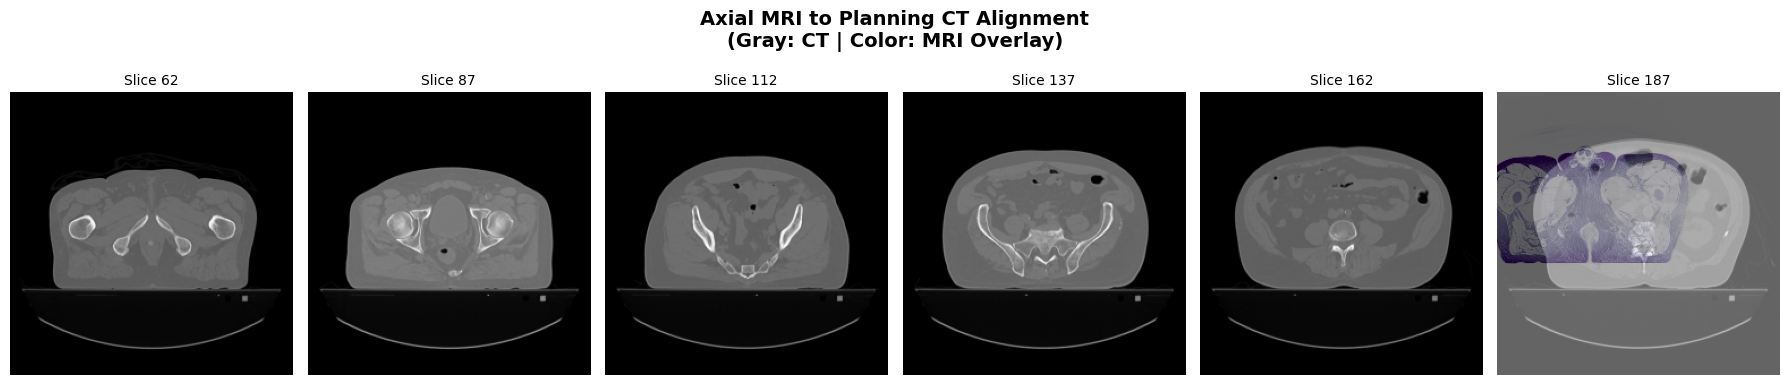


✅ Visualization complete!


In [ ]:
# === 14. VISUALIZATION ===

print("\n" + "="*60)
print("GENERATING ALIGNMENT VISUALIZATION")
print("="*60)

num_mri = len(mri_aligned)
num_display_slices = 6
slice_indices = np.linspace(ct_plan_iso.shape[2] // 4, 
                           3 * ct_plan_iso.shape[2] // 4, 
                           num_display_slices, dtype=int)

fig, axes = plt.subplots(num_mri, num_display_slices, 
                        figsize=(3*num_display_slices, 4*num_mri))

if num_mri == 1:
    axes = axes.reshape(1, -1)

ct_display = np.clip(ct_plan_iso, -1000, 3000)
mri_cmaps = ['Purples', 'Greens', 'Blues', 'Reds']

for row_idx, (name, mri_vol) in enumerate(mri_aligned.items()):
    quality = alignment_quality[name]
    cmap = mri_cmaps[row_idx % len(mri_cmaps)]
    
    border_color = 'green' if quality['nmi'] > 0.4 else 'yellow' if quality['nmi'] > 0.25 else 'orange' if quality['nmi'] > 0.15 else 'red'
    
    for col_idx, slice_num in enumerate(slice_indices):
        ax = axes[row_idx, col_idx]
        
        ax.imshow(ct_display[:, :, slice_num], cmap='gray', alpha=1.0)
        
        mri_slice = mri_vol[:, :, slice_num]
        if np.max(mri_slice) > 0:
            mri_norm = (mri_slice - np.percentile(mri_slice[mri_slice > 0], 1)) / \
                       (np.percentile(mri_slice[mri_slice > 0], 99) - 
                        np.percentile(mri_slice[mri_slice > 0], 1) + 1e-8)
            mri_norm = np.clip(mri_norm, 0, 1)
            ax.imshow(mri_norm, cmap=cmap, alpha=0.4)
        
        if col_idx == 0:
            ax.set_ylabel(f"{name}\nNMI={quality['nmi']:.3f}", fontsize=10, fontweight='bold')
        
        if row_idx == 0:
            ax.set_title(f"Slice {slice_num}", fontsize=10)
        
        ax.axis('off')
        
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(2)
            spine.set_visible(True)

fig.suptitle('Axial MRI to Planning CT Alignment\n(Gray: CT | Color: MRI Overlay)', 
             fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()

print("\n✅ Visualization complete!")

In [ ]:
# === 15. DICOM EXPORT ===

import time
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import generate_uid, ExplicitVRLittleEndian

print("\n" + "="*60)
print("EXPORTING ALIGNED VOLUMES AS DICOM")
print("="*60)

patient_id = "MRI_CT_Aligned"
patient_name = "MRI^CT^Registered"
study_uid = generate_uid()
for_uid = generate_uid()

spacing_row, spacing_col, spacing_slc = ct_plan_iso_meta['spacing']
origin = np.array(ct_plan_iso_meta['origin'], dtype=float)
iop = [float(x) for x in ct_plan_iso_meta['orientation']]
row_cos = np.array(iop[0:3], dtype=float)
col_cos = np.array(iop[3:6], dtype=float)
slc_cos = np.cross(row_cos, col_cos)
slc_cos = slc_cos / (np.linalg.norm(slc_cos) + 1e-8)

def make_file_meta(sop_class_uid, sop_instance_uid):
    fm = FileMetaDataset()
    fm.FileMetaInformationVersion = b'\x00\x01'
    fm.MediaStorageSOPClassUID = sop_class_uid
    fm.MediaStorageSOPInstanceUID = sop_instance_uid
    fm.TransferSyntaxUID = ExplicitVRLittleEndian
    fm.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID
    return fm

def new_image_ds(rows, cols, modality, series_desc, series_uid, series_number,
                 iop_list, ipp_xyz, pixel_spacing, slice_thickness,
                 photometric="MONOCHROME2", pixel_repr=1,
                 rescale_slope=1.0, rescale_intercept=0.0,
                 sop_class_uid="1.2.840.10008.5.1.4.1.1.2"):
    ds = Dataset()
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.StudyInstanceUID = study_uid
    ds.StudyDate = time.strftime("%Y%m%d")
    ds.StudyTime = time.strftime("%H%M%S")
    ds.StudyDescription = "MRI-CT Registration for RT Planning"
    ds.Modality = modality
    ds.SeriesInstanceUID = series_uid
    ds.SeriesNumber = series_number
    ds.SeriesDescription = series_desc
    ds.FrameOfReferenceUID = for_uid
    ds.ImageOrientationPatient = [float(x) for x in iop_list]
    ds.ImagePositionPatient = [float(x) for x in ipp_xyz]
    ds.PixelSpacing = [float(pixel_spacing[0]), float(pixel_spacing[1])]
    ds.SliceThickness = float(slice_thickness)
    ds.SpacingBetweenSlices = float(slice_thickness)
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = photometric
    ds.Rows = int(rows)
    ds.Columns = int(cols)
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = int(pixel_repr)
    ds.RescaleSlope = float(rescale_slope)
    ds.RescaleIntercept = float(rescale_intercept)
    
    if modality == "CT":
        ds.WindowCenter = 40
        ds.WindowWidth = 400
    else:
        ds.WindowCenter = 500
        ds.WindowWidth = 1000
    
    ds.SOPClassUID = sop_class_uid
    sop_iuid = generate_uid()
    ds.SOPInstanceUID = sop_iuid
    ds.file_meta = make_file_meta(sop_class_uid, sop_iuid)
    ds.is_implicit_VR = False
    ds.is_little_endian = True
    return ds

def write_series(volume, folder_name, modality, series_number, pixel_repr,
                 rescale_slope, rescale_intercept, sop_class_uid, 
                 series_description, scale_clamp=None):
    series_path = os.path.join(OUTPUT_DICOM_DIR, folder_name)
    os.makedirs(series_path, exist_ok=True)
    
    R, C, K = volume.shape
    series_uid = generate_uid()
    
    v = np.copy(volume)
    if scale_clamp is not None:
        v = np.clip(v, scale_clamp[0], scale_clamp[1])
    
    if pixel_repr == 1:
        stored = np.round((v - rescale_intercept) / rescale_slope).astype(np.int16)
    else:
        v = np.maximum(v, 0.0)
        stored = np.round((v - rescale_intercept) / rescale_slope).astype(np.uint16)
    
    for k in range(K):
        ipp = origin + slc_cos * spacing_slc * k
        
        ds = new_image_ds(
            rows=R, cols=C,
            modality=modality,
            series_desc=series_description,
            series_uid=series_uid,
            series_number=series_number,
            iop_list=iop,
            ipp_xyz=ipp.tolist(),
            pixel_spacing=[spacing_row, spacing_col],
            slice_thickness=spacing_slc,
            photometric="MONOCHROME2",
            pixel_repr=pixel_repr,
            rescale_slope=rescale_slope,
            rescale_intercept=rescale_intercept,
            sop_class_uid=sop_class_uid
        )
        
        ds.InstanceNumber = int(k + 1)
        ds.ImageType = ['DERIVED', 'SECONDARY']
        ds.AcquisitionNumber = 1
        ds.ContentDate = ds.StudyDate
        ds.ContentTime = ds.StudyTime
        ds.PixelData = stored[:, :, k].tobytes(order='C')
        
        out_path = os.path.join(series_path, f"IM_{k+1:04d}.dcm")
        pydicom.dcmwrite(out_path, ds, write_like_original=False)
    
    print(f"✓ Wrote {K} slices to {series_path}")
    return series_path

# Export CT
ct_folder = write_series(
    volume=ct_plan_iso,
    folder_name="CT",
    modality="CT",
    series_number=1,
    pixel_repr=1,
    rescale_slope=1.0,
    rescale_intercept=0.0,
    sop_class_uid="1.2.840.10008.5.1.4.1.1.2",
    series_description="Planning CT (Reference)",
    scale_clamp=(-1024, 3071)
)

# Export each aligned MRI
series_num = 2
for name, mri_vol in mri_aligned.items():
    max_val = np.max(mri_vol)
    scale = max_val / 65535.0 if max_val > 0 else 1.0
    
    write_series(
        volume=mri_vol,
        folder_name=f"MRI_{name}",
        modality="MR",
        series_number=series_num,
        pixel_repr=0,
        rescale_slope=scale,
        rescale_intercept=0.0,
        sop_class_uid="1.2.840.10008.5.1.4.1.1.4",
        series_description=f"{name} (Aligned to CT)",
        scale_clamp=(0.0, max_val)
    )
    series_num += 1

print("\n" + "="*60)
print("DICOM EXPORT COMPLETE")
print("="*60)
print(f"📁 Output: {OUTPUT_DICOM_DIR}")
print(f"✅ {len(mri_aligned) + 1} series exported")
print(f"\n💡 Import into 3D Slicer:")
print(f"   File → Add Data → Choose Directory → {OUTPUT_DICOM_DIR}")
print(f"   All volumes share the same FrameOfReference (pre-aligned)")


EXPORTING ALIGNED VOLUMES AS DICOM
✓ Wrote 250 slices to c:\Users\zhaoanr\Desktop\ct2-mri-registration\AlignedMRI_CT\CT
✓ Wrote 250 slices to c:\Users\zhaoanr\Desktop\ct2-mri-registration\AlignedMRI_CT\MRI_T2_SPACE

DICOM EXPORT COMPLETE
📁 Output: c:\Users\zhaoanr\Desktop\ct2-mri-registration\AlignedMRI_CT
✅ 2 series exported

💡 Import into 3D Slicer:
   File → Add Data → Choose Directory → c:\Users\zhaoanr\Desktop\ct2-mri-registration\AlignedMRI_CT
   All volumes share the same FrameOfReference (pre-aligned)


In [ ]:
# === 16. SUMMARY REPORT ===

print("\n" + "="*80)
print(" " * 25 + "REGISTRATION SUMMARY")
print("="*80)

print("\n📊 VOLUMES PROCESSED:")
print(f"  • Planning CT: {ct_plan_iso.shape} @ {TARGET_SPACING}mm³")
for name, vol in mri_aligned.items():
    print(f"  • {name}: {vol.shape} @ {TARGET_SPACING}mm³")

print("\n🎯 ALIGNMENT QUALITY:")
for name, quality in alignment_quality.items():
    print(f"  • {name}: NMI={quality['nmi']:.4f} ({quality['label']}) {quality['color']}")

print("\n💾 OUTPUT:")
print(f"  Location: {OUTPUT_DICOM_DIR}")
print(f"  Series: {len(mri_aligned) + 1} (CT + {len(mri_aligned)} MRI)")

print("\n✅ REGISTRATION COMPLETE")
print("="*80)


                         REGISTRATION SUMMARY

📊 VOLUMES PROCESSED:
  • Planning CT: (250, 250, 250) @ 2.0mm³
  • T2_SPACE: (250, 250, 250) @ 2.0mm³

🎯 ALIGNMENT QUALITY:
  • T2_SPACE: NMI=0.0092 (Check Alignment) 🔴

💾 OUTPUT:
  Location: c:\Users\zhaoanr\Desktop\ct2-mri-registration\AlignedMRI_CT
  Series: 2 (CT + 1 MRI)

✅ REGISTRATION COMPLETE
